# GPN-MSA Testing with PRVCS PAT, CAN, and REG Datasets

## Setup environment 

In [ ]:
# only need once for GPN-MSA use
# !pip install git+https://github.com/songlab-cal/gpn.git

In [ ]:
# !ldconfig /usr/lib64-nvidia

In [1]:
from gpn.data import GenomeMSA, Tokenizer
import gpn.model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import torch
from transformers import AutoModel, AutoModelForMaskedLM

/cm/shared/apps/spack/0.17.3/cpu/b/opt/spack/linux-rocky8-zen/gcc-8.5.0/anaconda3-2021.05-q4munrgvh7qp4o7r3nzcdkbuph4z7375/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
from datasets import load_dataset, disable_caching
from gpn.data import load_dataset_from_file_or_dir

In [3]:
dataset_prefix = "/expanse/lustre/projects/nji102/sgriesmer/gpn/Datasets/"

In [ ]:
input_file =  dataset_prefix + "test.parquet"
dataset = load_dataset_from_file_or_dir(input_file, split="test", is_file=True)

## Pathogenic Dataset

## Load scored dataset (if previously created)

In [4]:
df_pathogenic_set = pd.read_csv(dataset_prefix + "PRVCS/PAT_dataset_XY-named-plus-gpncons.csv", sep=',')
df_pathogenic_set.head(), df_pathogenic_set.shape

(            Name   label    gpn_score
 0  SNP_PAT_00001  Common   -1.5404252
 1  SNP_PAT_00002  Common   0.19373989
 2  SNP_PAT_00003  Common   -2.5867186
 3  SNP_PAT_00004  Common  -0.76693577
 4  SNP_PAT_00005  Common   -1.6453758,
 (11436, 3))

## Drop rows with "No scores"

In [5]:
df_pathogenic_set = df_pathogenic_set[df_pathogenic_set["gpn_score"].str.contains("No score") == False]
df_pathogenic_set

,Name,label,gpn_score
0,SNP_PAT_00001,Common,-1.5404252
1,SNP_PAT_00002,Common,0.19373989
2,SNP_PAT_00003,Common,-2.5867186
3,SNP_PAT_00004,Common,-0.76693577
4,SNP_PAT_00005,Common,-1.6453758
...,...,...,...
11431,SNP_PAT_11432,Pathogenic,-5.67437
11432,SNP_PAT_11433,Pathogenic,-8.000279
11433,SNP_PAT_11434,Pathogenic,-6.372505
11434,SNP_PAT_11435,Pathogenic,-6.439803


## Convert gpn_score to floating point

In [6]:
df_pathogenic_set['gpn_score'] = df_pathogenic_set['gpn_score'].astype(float)
df_pathogenic_set

,Name,label,gpn_score
0,SNP_PAT_00001,Common,-1.540425
1,SNP_PAT_00002,Common,0.193740
2,SNP_PAT_00003,Common,-2.586719
3,SNP_PAT_00004,Common,-0.766936
4,SNP_PAT_00005,Common,-1.645376
...,...,...,...
11431,SNP_PAT_11432,Pathogenic,-5.674370
11432,SNP_PAT_11433,Pathogenic,-8.000279
11433,SNP_PAT_11434,Pathogenic,-6.372505
11434,SNP_PAT_11435,Pathogenic,-6.439803


## Plot shows differentiation between Common and Pathogenic mutations

<AxesSubplot:xlabel='gpn_score', ylabel='Count'>

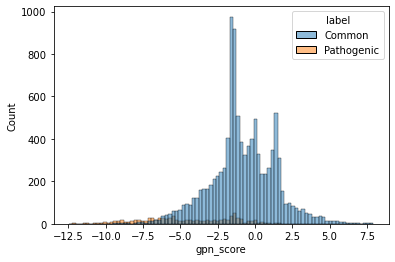

In [7]:
sns.histplot(data=df_pathogenic_set, x="gpn_score", hue="label")

## Calculate metrics

In [8]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

AUROC = roc_auc_score(df_pathogenic_set.label=="Pathogenic", -df_pathogenic_set.gpn_score)
AUPRC = average_precision_score(df_pathogenic_set.label=="Pathogenic", -df_pathogenic_set.gpn_score)
AUROC, AUPRC

(0.8266347969395615, 0.4898646964614233)

## Plot ROC curve

In [9]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(df_pathogenic_set.label=="Pathogenic", -df_pathogenic_set.gpn_score)

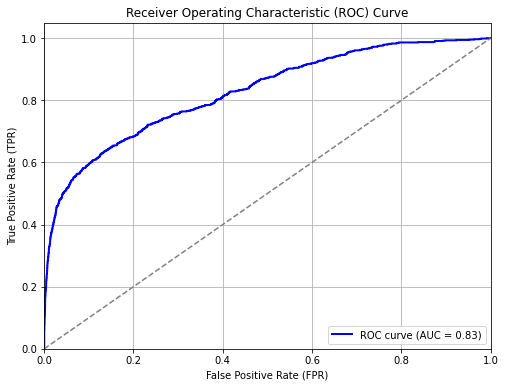

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {AUROC:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [11]:
from numpy import asarray
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot

In [12]:
X = df_pathogenic_set['gpn_score']
y = df_pathogenic_set['label']

In [13]:
X = X.values.reshape(-1,1)

In [14]:
X

array([[-1.5404252 ],
       [ 0.19373989],
       [-2.5867186 ],
       ...,
       [-6.372505  ],
       [-6.439803  ],
       [ 0.09025609]])

In [15]:
y = df_pathogenic_set['label'] == 'Pathogenic'
y = y.astype(int)

In [16]:
y

0        0
1        0
2        0
3        0
4        0
        ..
11431    1
11432    1
11433    1
11434    1
11435    1
Name: label, Length: 11393, dtype: int64

In [17]:
from sklearn.model_selection import train_test_split
test_size = 0.3
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [18]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(solver='lbfgs', max_iter=1000)
lr_train_model = lr_model.fit(X_train,y_train)
pred_lr = lr_model.predict(X_test)

In [19]:
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, roc_auc_score

print("Accuracy_model_lr: %.4f" % (accuracy_score(y_test, pred_lr))) 
print("F1_model_lr: %.4f" % (f1_score(y_test, pred_lr)))
print("MCC_model_lr: %.4f" % (matthews_corrcoef(y_test, pred_lr)))
print("ROC_AUC_model_lr: %.4f" % (roc_auc_score(y_test, pred_lr))) # don't know about call: y_score vs. pred

Accuracy_model_lr: 0.9269
F1_model_lr: 0.3316
MCC_model_lr: 0.3682
ROC_AUC_model_lr: 0.6038


In [20]:
model1 = XGBClassifier() 
model2 = XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, subsample=0.5) 
train_model1 = model1.fit(X_train, y_train) 
train_model2 = model2.fit(X_train, y_train) 
pred1 = train_model1.predict(X_test) 
pred2 = train_model2.predict(X_test) 
print("Accuracy_model1: %.4f" % (accuracy_score(y_test, pred1))) 
print("Accuracy_model2: %.4f" % (accuracy_score(y_test, pred2))) 
print("F1_model1: %.4f" % (f1_score(y_test, pred1)))
print("F1_model2: %.4f" % (f1_score(y_test, pred2)))
print("MCC_model1: %.4f" % (matthews_corrcoef(y_test, pred1)))
print("MCC_model2: %.4f" % (matthews_corrcoef(y_test, pred2)))
print("ROC_AUC_model1: %.4f" % (roc_auc_score(y_test, pred1))) # don't know about call: y_score vs. pred
print("ROC_AUC_model2: %.4f" % (roc_auc_score(y_test, pred2))) # don't know about call: y_score vs. pred

Accuracy_model1: 0.9292
Accuracy_model2: 0.9301
F1_model1: 0.3763
F1_model2: 0.3949
MCC_model1: 0.4036
MCC_model2: 0.4172
ROC_AUC_model1: 0.6224
ROC_AUC_model2: 0.6308


In [21]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, pred1).ravel()
print(tp, fp, fn, tn)

73 27 215 3103


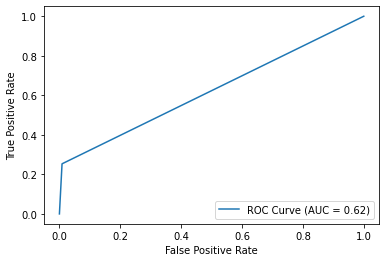

In [22]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, pred1)
roc_auc = roc_auc_score(y_test, pred1)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot(name="ROC Curve")

In [23]:
model3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=7)

train_model3 = model3.fit(X_train, y_train)
pred3 = train_model3.predict(X_test)
print("Accuracy_model3: %.4f" % (accuracy_score(y_test, pred3)))
print("F1_model3: %.4f" % (f1_score(y_test, pred3)))
print("MCC_model3: %.4f" % (matthews_corrcoef(y_test, pred3)))
print("ROC_AUC_model3: %.4f" % (roc_auc_score(y_test, pred3))) # don't know about call: y_score vs. pred

Accuracy_model3: 0.9292
F1_model3: 0.3763
MCC_model3: 0.4036
ROC_AUC_model3: 0.6224


In [24]:
model_regbase = XGBClassifier(
    colsample_bylevel = 0.3,
    colsample_bytree = 1.0,
    gamma = 3.6,
    learning_rate = 0.1,
    max_depth = 8,
    min_child_weight = 3,
    n_estimators = 100,
    reg_alpha = 0.001,
    reg_lambda = 2,
    scale_pos_weight = 12.1599539701,
    subsample = 0.7)

train_model_regbase = model_regbase.fit(X_train, y_train)
pred_regbase = train_model_regbase.predict(X_test)
print("Accuracy_model_regbase: %.4f" % (accuracy_score(y_test, pred_regbase)))
print("F1_model_regbase: %.4f" % (f1_score(y_test, pred_regbase)))
print("MCC_model_regbase: %.4f" % (matthews_corrcoef(y_test, pred_regbase)))
print("ROC_AUC_model_regbase: %.4f" % (roc_auc_score(y_test, pred_regbase)))

Accuracy_model_regbase: 0.8198
F1_model_regbase: 0.3663
MCC_model_regbase: 0.3169
ROC_AUC_model_regbase: 0.7282


In [25]:
import xgboost as xgb

data_matrix = xgb.DMatrix(data=X, label=y)

params = {
    "colsample_bylevel": 0.3,
    "colsample_bytree": 1.0,
    "gamma": 3.6,
    "learning_rate": 0.1,
    "max_depth": 8,
    "min_child_weight": 3,
    "alpha": 0.001,
    "lambda": 2,
    "scale_pos_weight": 12.1599539701,
    "subsample": 0.7
}

xgb_cv = xgb.cv(dtrain=data_matrix, params=params, nfold=10,
                    num_boost_round=100, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=7)

In [26]:
xgb_cv

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.836722,0.004076,0.812844,0.026510
1,0.840395,0.003079,0.818270,0.021587
2,0.842696,0.003522,0.820475,0.021129
3,0.844159,0.003541,0.821075,0.022778
4,0.844877,0.003580,0.820197,0.022356
5,0.844947,0.003892,0.820751,0.021636
6,0.845480,0.003596,0.821411,0.021434
7,0.845503,0.003691,0.822596,0.022179
8,0.845686,0.003772,0.822614,0.022292
9,0.845803,0.003562,0.822880,0.022113


In [27]:
model_regbase.set_params(n_estimators=xgb_cv.shape[0])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.3, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3.6, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=35, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [28]:
train_model_regbase_cv = model_regbase.fit(X_train,y_train)
pred_regbase_cv = train_model_regbase.predict(X_test)
print("Accuracy_model_regbase: %.4f" % (accuracy_score(y_test, pred_regbase_cv)))
print("F1_model_regbase: %.4f" % (f1_score(y_test, pred_regbase_cv)))
print("MCC_model_regbase: %.4f" % (matthews_corrcoef(y_test, pred_regbase_cv)))
print("ROC_AUC_model_regbase: %.4f" % (roc_auc_score(y_test, pred_regbase_cv)))

Accuracy_model_regbase: 0.8461
F1_model_regbase: 0.3968
MCC_model_regbase: 0.3464
ROC_AUC_model_regbase: 0.7347


In [29]:
from sklearn.model_selection import GridSearchCV

param_test = {
 'max_depth': range(2,10,2),
 'min_child_weight': range(2,10,2)
}
    
gsearch = GridSearchCV(estimator=XGBClassifier(colsample_bylevel = 0.3,
                                                colsample_bytree = 1.0,
                                                gamma = 3.6,
                                                learning_rate = 0.1,
                                                max_depth = 8,
                                                min_child_weight = 3,
                                                n_estimators = 27,
                                                objective = 'binary:logistic',
                                                reg_alpha = 0.001,
                                                reg_lambda = 2,
                                                scale_pos_weight = 12.1599539701,
                                                subsample = 0.7), 
                       param_grid=param_test, 
                       scoring='roc_auc',
                       n_jobs=4, 
                       verbose=4,
                       return_train_score=True,
                       cv=10,
                       refit=True)

train_model_regbase_cv3 = gsearch.fit(X_train, y_train)
pred_regbase_cv3 = train_model_regbase_cv3.predict(X_test)
print("Accuracy_model_cv3: %.4f" % (accuracy_score(y_test, pred_regbase_cv3)))  
print("F1_model_cv3: %.4f" % (f1_score(y_test, pred_regbase_cv3)))  
print("MCC_model_cv3: %.4f" % (matthews_corrcoef(y_test, pred_regbase_cv3)))  
print("ROC_AUC_model_cv3: %.4f" % (roc_auc_score(y_test, pred_regbase_cv3)))  

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Accuracy_model_cv3: 0.8806
F1_model_cv3: 0.4441
MCC_model_cv3: 0.3922
ROC_AUC_model_cv3: 0.7378


In [30]:
gsearch.cv_results_['params'][gsearch.best_index_]

{'max_depth': 2, 'min_child_weight': 2}

In [31]:
param_test = {
 'max_depth': [1,2],
 'min_child_weight': [1,2]
}
    
gsearch = GridSearchCV(estimator=XGBClassifier(colsample_bylevel = 0.3,
                                                colsample_bytree = 1.0,
                                                gamma = 3.6,
                                                learning_rate = 0.1,
                                                max_depth = 8,
                                                min_child_weight = 3,
                                                n_estimators = 27,
                                                objective = 'binary:logistic',
                                                reg_alpha = 0.001,
                                                reg_lambda = 2,
                                                scale_pos_weight = 12.1599539701,
                                                subsample = 0.7), 
                       param_grid=param_test, 
                       scoring='roc_auc',
                       n_jobs=4, 
                       verbose=4,
                       return_train_score=True,
                       cv=10,
                       refit=True)

train_model_regbase_cv4 = gsearch.fit(X_train, y_train)
pred_regbase_cv4 = train_model_regbase_cv4.predict(X_test)
print("Accuracy_model_cv4: %.4f" % (accuracy_score(y_test, pred_regbase_cv4)))  
print("F1_model_cv4: %.4f" % (f1_score(y_test, pred_regbase_cv4)))  
print("MCC_model_cv4: %.4f" % (matthews_corrcoef(y_test, pred_regbase_cv4)))  
print("ROC_AUC_model_cv4: %.4f" % (roc_auc_score(y_test, pred_regbase_cv4)))  

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Accuracy_model_cv4: 0.8806
F1_model_cv4: 0.4441
MCC_model_cv4: 0.3922
ROC_AUC_model_cv4: 0.7378


In [65]:
param_test = {
 'gamma': range(2,6),
}
    
gsearch = GridSearchCV(estimator=XGBClassifier(colsample_bylevel = 0.3,
                                                colsample_bytree = 1.0,
                                                gamma = 3.6,
                                                learning_rate = 0.1,
                                                max_depth = 9,
                                                min_child_weight = 9,
                                                n_estimators = 27,
                                                objective = 'binary:logistic',
                                                reg_alpha = 0.001,
                                                reg_lambda = 2,
                                                scale_pos_weight = 12.1599539701,
                                                subsample = 0.7), 
                       param_grid=param_test, 
                       scoring='roc_auc',
                       n_jobs=4, 
                       verbose=4,
                       return_train_score=True,
                       cv=10,
                       refit=True)

train_model_regbase_cv5 = gsearch.fit(X_train, y_train)
pred_regbase_cv5 = train_model_regbase_cv5.predict(X_test)
print("Accuracy_model_cv5: %.4f" % (accuracy_score(y_test, pred_regbase_cv5)))  
print("F1_model_cv5: %.4f" % (f1_score(y_test, pred_regbase_cv5)))  
print("MCC_model_cv5: %.4f" % (matthews_corrcoef(y_test, pred_regbase_cv5)))  
print("ROC_AUC_model_cv5: %.4f" % (roc_auc_score(y_test, pred_regbase_cv5))) 

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Accuracy_model_cv5: 0.8406
F1_model_cv5: 0.3911
MCC_model_cv5: 0.3413
ROC_AUC_model_cv5: 0.7348


In [66]:
param_test = {
  'subsample': [i/10.0 for i in range(6,10)],
  'colsample_bytree': [i/10.0 for i in range(6,10)]
}
    
gsearch = GridSearchCV(estimator=XGBClassifier(colsample_bylevel = 0.3,
                                                colsample_bytree = 1.0,
                                                gamma = 3.6,
                                                learning_rate = 0.1,
                                                max_depth = 9,
                                                min_child_weight = 9,
                                                n_estimators = 27,
                                                objective = 'binary:logistic',
                                                reg_alpha = 0.001,
                                                reg_lambda = 2,
                                                scale_pos_weight = 12.1599539701,
                                                subsample = 0.7), 
                       param_grid=param_test, 
                       scoring='roc_auc',
                       n_jobs=4, 
                       verbose=4,
                       return_train_score=True,
                       cv=10,
                       refit=True)

train_model_regbase_cv6 = gsearch.fit(X_train, y_train)
pred_regbase_cv6 = train_model_regbase_cv6.predict(X_test)
print("Accuracy_model_cv6: %.4f" % (accuracy_score(y_test, pred_regbase_cv6)))  
print("F1_model_cv6: %.4f" % (f1_score(y_test, pred_regbase_cv6)))  
print("MCC_model_cv6: %.4f" % (matthews_corrcoef(y_test, pred_regbase_cv6)))  
print("ROC_AUC_model_cv6: %.4f" % (roc_auc_score(y_test, pred_regbase_cv6))) 

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Accuracy_model_cv6: 0.8449
F1_model_cv6: 0.3950
MCC_model_cv6: 0.3445
ROC_AUC_model_cv6: 0.7341


In [67]:
param_test = {
  'reg_alpha':[1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1],
}
    
gsearch = GridSearchCV(estimator=XGBClassifier(colsample_bylevel = 0.3,
                                                colsample_bytree = 0.7,
                                                gamma = 3.6,
                                                learning_rate = 0.1,
                                                max_depth = 9,
                                                min_child_weight = 9,
                                                n_estimators = 27,
                                                objective = 'binary:logistic',
                                                reg_alpha = 0.001,
                                                reg_lambda = 2,
                                                scale_pos_weight = 12.1599539701,
                                                subsample = 0.9), 
                       param_grid=param_test, 
                       scoring='roc_auc',
                       n_jobs=4, 
                       verbose=4,
                       return_train_score=True,
                       cv=10,
                       refit=True)

train_model_regbase_cv7 = gsearch.fit(X_train, y_train)
pred_regbase_cv7 = train_model_regbase_cv7.predict(X_test)
print("Accuracy_model_cv7: %.4f" % (accuracy_score(y_test, pred_regbase_cv7)))  
print("F1_model_cv7: %.4f" % (f1_score(y_test, pred_regbase_cv7)))  
print("MCC_model_cv7: %.4f" % (matthews_corrcoef(y_test, pred_regbase_cv7)))  
print("ROC_AUC_model_cv7: %.4f" % (roc_auc_score(y_test, pred_regbase_cv7))) 

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Accuracy_model_cv7: 0.8490
F1_model_cv7: 0.3958
MCC_model_cv7: 0.3437
ROC_AUC_model_cv7: 0.7300


In [68]:
param_test = {
  'learning_rate':[0.01, 0.05, 0.1, 0.15, 0.2],
}
    
gsearch = GridSearchCV(estimator=XGBClassifier(colsample_bylevel = 0.3,
                                                colsample_bytree = 0.7,
                                                gamma = 3.6,
                                                learning_rate = 0.1,
                                                max_depth = 9,
                                                min_child_weight = 9,
                                                n_estimators = 27,
                                                objective = 'binary:logistic',
                                                reg_alpha = 0.001,
                                                reg_lambda = 2,
                                                scale_pos_weight = 12.1599539701,
                                                subsample = 0.9), 
                       param_grid=param_test, 
                       scoring='roc_auc',
                       n_jobs=4, 
                       verbose=4,
                       return_train_score=True,
                       cv=10,
                       refit=True)

train_model_regbase_cv9 = gsearch.fit(X_train, y_train)
pred_regbase_cv9 = train_model_regbase_cv9.predict(X_test)
print("Accuracy_model_cv9: %.4f" % (accuracy_score(y_test, pred_regbase_cv9)))  
print("F1_model_cv9: %.4f" % (f1_score(y_test, pred_regbase_cv9)))  
print("MCC_model_cv9: %.4f" % (matthews_corrcoef(y_test, pred_regbase_cv9)))  
print("ROC_AUC_model_cv9: %.4f" % (roc_auc_score(y_test, pred_regbase_cv9))) 

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Accuracy_model_cv9: 0.8449
F1_model_cv9: 0.3950
MCC_model_cv9: 0.3445
ROC_AUC_model_cv9: 0.7341


## Cancer Dataset

## Load scored dataset (if previously created)

In [32]:
df_cancer_set = pd.read_csv(dataset_prefix + "CAN_dataset_XY-named-plus-gpncons.csv", sep=',')
df_cancer_set.head(), df_cancer_set.shape

(           Name   label    gpn_score
 0  SNP_CAN_0001  Common  -0.53121036
 1  SNP_CAN_0002  Common   -1.7068372
 2  SNP_CAN_0003  Common    0.5689588
 3  SNP_CAN_0004  Common   -1.8153526
 4  SNP_CAN_0005  Common   -1.3809743,
 (5023, 3))

## Drop rows with "No score"

In [33]:
df_cancer_set = df_cancer_set[df_cancer_set["gpn_score"].str.contains("No score") == False]
df_cancer_set

,Name,label,gpn_score
0,SNP_CAN_0001,Common,-0.53121036
1,SNP_CAN_0002,Common,-1.7068372
2,SNP_CAN_0003,Common,0.5689588
3,SNP_CAN_0004,Common,-1.8153526
4,SNP_CAN_0005,Common,-1.3809743
...,...,...,...
5018,SNP_CAN_5019,Cancer,-3.5750618
5019,SNP_CAN_5020,Cancer,-0.08785868
5020,SNP_CAN_5021,Cancer,-2.124812
5021,SNP_CAN_5022,Cancer,1.5109184


## Convert 'gpn_score' to floating point

In [34]:
df_cancer_set['gpn_score'] = df_cancer_set['gpn_score'].astype(float)
df_cancer_set

,Name,label,gpn_score
0,SNP_CAN_0001,Common,-0.531210
1,SNP_CAN_0002,Common,-1.706837
2,SNP_CAN_0003,Common,0.568959
3,SNP_CAN_0004,Common,-1.815353
4,SNP_CAN_0005,Common,-1.380974
...,...,...,...
5018,SNP_CAN_5019,Cancer,-3.575062
5019,SNP_CAN_5020,Cancer,-0.087859
5020,SNP_CAN_5021,Cancer,-2.124812
5021,SNP_CAN_5022,Cancer,1.510918


## Plot shows differentiation between Common and COSMIC/Frequent mutations

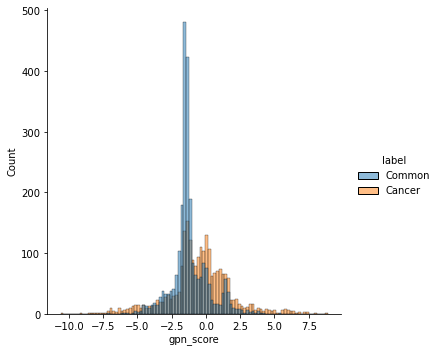

In [35]:
sns.displot(data=df_cancer_set, hue="label", x="gpn_score")

## Calculate metrics

In [36]:
from sklearn.metrics import roc_auc_score, average_precision_score

gpn_score = df_cancer_set.gpn_score
AUROC = roc_auc_score(df_cancer_set.label=="Cancer", -gpn_score)
AUPRC = average_precision_score(df_cancer_set.label=="Cancer", -gpn_score)
AUROC, AUPRC

(0.3563820256960138, 0.4630926601877383)

## Plot ROC curve

In [37]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(df_cancer_set.label=="Cancer", -gpn_score)

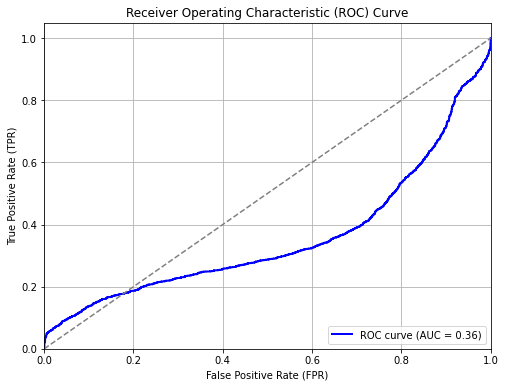

In [38]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {AUROC:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [39]:
from numpy import asarray
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot

In [51]:
X = df_cancer_set['gpn_score']
y = df_cancer_set['label']

In [55]:
X

array([[-0.53121036],
       [-1.7068372 ],
       [ 0.5689588 ],
       ...,
       [-2.124812  ],
       [ 1.5109184 ],
       [-1.6876688 ]])

In [56]:
#X = X.values.reshape(-1,1)
y = df_cancer_set['label'] == 'Cancer'
y = y.astype(int)

In [57]:
from sklearn.model_selection import train_test_split
test_size = 0.3
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [58]:
X

array([[-0.53121036],
       [-1.7068372 ],
       [ 0.5689588 ],
       ...,
       [-2.124812  ],
       [ 1.5109184 ],
       [-1.6876688 ]])

In [59]:
y

0       0
1       0
2       0
3       0
4       0
       ..
5018    1
5019    1
5020    1
5021    1
5022    1
Name: label, Length: 4830, dtype: int64

In [60]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(solver='lbfgs', max_iter=1000)
lr_train_model = lr_model.fit(X_train,y_train)
pred_lr = lr_model.predict(X_test)

In [61]:
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, roc_auc_score

print("Accuracy_model_lr: %.4f" % (accuracy_score(y_test, pred_lr))) 
print("F1_model_lr: %.4f" % (f1_score(y_test, pred_lr)))
print("MCC_model_lr: %.4f" % (matthews_corrcoef(y_test, pred_lr)))
print("ROC_AUC_model_lr: %.4f" % (roc_auc_score(y_test, pred_lr))) # don't know about call: y_score vs. pred

Accuracy_model_lr: 0.6308
F1_model_lr: 0.5589
MCC_model_lr: 0.2711
ROC_AUC_model_lr: 0.6288


In [62]:
model1 = XGBClassifier() 
model2 = XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, subsample=0.5) 
train_model1 = model1.fit(X_train, y_train) 
train_model2 = model2.fit(X_train, y_train) 
pred1 = train_model1.predict(X_test) 
pred2 = train_model2.predict(X_test) 
print("Accuracy_model1: %.4f" % (accuracy_score(y_test, pred1))) 
print("Accuracy_model2: %.4f" % (accuracy_score(y_test, pred2))) 
print("F1_model1: %.4f" % (f1_score(y_test, pred1)))
print("F1_model2: %.4f" % (f1_score(y_test, pred2)))
print("MCC_model1: %.4f" % (matthews_corrcoef(y_test, pred1)))
print("MCC_model2: %.4f" % (matthews_corrcoef(y_test, pred2)))
print("ROC_AUC_model1: %.4f" % (roc_auc_score(y_test, pred1))) # don't know about call: y_score vs. pred
print("ROC_AUC_model2: %.4f" % (roc_auc_score(y_test, pred2))) # don't know about call: y_score vs. pred

Accuracy_model1: 0.6363
Accuracy_model2: 0.6391
F1_model1: 0.6099
F1_model2: 0.6152
MCC_model1: 0.2731
MCC_model2: 0.2784
ROC_AUC_model1: 0.6355
ROC_AUC_model2: 0.6384


In [63]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, pred1).ravel()
print(tp, fp, fn, tn)

412 224 303 510


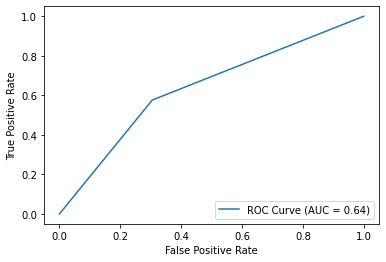

In [64]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, pred1)
roc_auc = roc_auc_score(y_test, pred1)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot(name="ROC Curve")

In [65]:
model3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=7)

train_model3 = model3.fit(X_train, y_train)
pred3 = train_model3.predict(X_test)
print("Accuracy_model3: %.4f" % (accuracy_score(y_test, pred3)))
print("F1_model3: %.4f" % (f1_score(y_test, pred3)))
print("MCC_model3: %.4f" % (matthews_corrcoef(y_test, pred3)))
print("ROC_AUC_model3: %.4f" % (roc_auc_score(y_test, pred3))) # don't know about call: y_score vs. pred


Accuracy_model3: 0.6342
F1_model3: 0.6091
MCC_model3: 0.2688
ROC_AUC_model3: 0.6335


In [66]:
model_regbase = XGBClassifier(
    colsample_bylevel = 0.5,
    colsample_bytree = 0.8,
    gamma = 0.0,
    learning_rate = 0.1,
    max_depth = 9,
    min_child_weight = 1,
    n_estimators = 200,
    reg_alpha = 0.0,
    reg_lambda = 1,
    scale_pos_weight = 0.9956297179,
    subsample = 0.8)

train_model_regbase = model_regbase.fit(X_train, y_train)
pred_regbase = train_model_regbase.predict(X_test)
print("Accuracy_model_regbase: %.4f" % (accuracy_score(y_test, pred_regbase)))
print("F1_model_regbase: %.4f" % (f1_score(y_test, pred_regbase)))
print("MCC_model_regbase: %.4f" % (matthews_corrcoef(y_test, pred_regbase)))
print("ROC_AUC_model_regbase: %.4f" % (roc_auc_score(y_test, pred_regbase)))

Accuracy_model_regbase: 0.6370
F1_model_regbase: 0.6127
MCC_model_regbase: 0.2743
ROC_AUC_model_regbase: 0.6363


In [67]:
tn, fp, fn, tp = confusion_matrix(y_test, pred_regbase).ravel()
print(tp, fp, fn, tn)

416 227 299 507


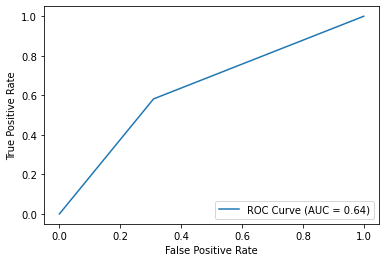

In [68]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, pred_regbase)
roc_auc = roc_auc_score(y_test, pred_regbase)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot(name="ROC Curve")

In [69]:
xgb_cv = xgb.cv(dtrain=data_matrix, params=params, nfold=10,
                    num_boost_round=100, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=7)

In [70]:
xgb_cv

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.836722,0.004076,0.812844,0.026510
1,0.840395,0.003079,0.818270,0.021587
2,0.842696,0.003522,0.820475,0.021129
3,0.844159,0.003541,0.821075,0.022778
4,0.844877,0.003580,0.820197,0.022356
5,0.844947,0.003892,0.820751,0.021636
6,0.845480,0.003596,0.821411,0.021434
7,0.845503,0.003691,0.822596,0.022179
8,0.845686,0.003772,0.822614,0.022292
9,0.845803,0.003562,0.822880,0.022113


In [71]:
model_regbase.set_params(n_estimators=xgb_cv.shape[0])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.5, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=35, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [72]:
rain_model_regbase_cv = model_regbase.fit(X_train,y_train)
pred_regbase_cv = train_model_regbase.predict(X_test)
print("Accuracy_model_regbase: %.4f" % (accuracy_score(y_test, pred_regbase_cv)))
print("F1_model_regbase: %.4f" % (f1_score(y_test, pred_regbase_cv)))
print("MCC_model_regbase: %.4f" % (matthews_corrcoef(y_test, pred_regbase_cv)))
print("ROC_AUC_model_regbase: %.4f" % (roc_auc_score(y_test, pred_regbase_cv)))

Accuracy_model_regbase: 0.6349
F1_model_regbase: 0.6079
MCC_model_regbase: 0.2703
ROC_AUC_model_regbase: 0.6341


In [21]:
## Regulatory Dataset

## Load Dataset to be Scored (if previously created)

In [22]:
## Load scored dataset (if previously created)

In [73]:
df_regulatory_set = pd.read_csv(dataset_prefix + "PRVCS/REG_dataset_XY-named-plus-gpncons.csv", sep=',')
df_regulatory_set.head(), df_regulatory_set.shape

(       Name       label   gpn_score
 0  SNP00001  Regulatory  -1.3505003
 1  SNP00002  Regulatory  -2.6757724
 2  SNP00003  Regulatory  -1.6896006
 3  SNP00004  Regulatory  -0.6497843
 4  SNP00005  Regulatory   1.4730732,
 (61170, 3))

## Drop rows with "No score"

In [74]:
df_regulatory_set = df_regulatory_set[df_regulatory_set["gpn_score"].str.contains("No score") == False]
df_regulatory_set

,Name,label,gpn_score
0,SNP00001,Regulatory,-1.3505003
1,SNP00002,Regulatory,-2.6757724
2,SNP00003,Regulatory,-1.6896006
3,SNP00004,Regulatory,-0.6497843
4,SNP00005,Regulatory,1.4730732
...,...,...,...
61165,SNP61166,Common,0.8097592
61166,SNP61167,Common,-0.43282062
61167,SNP61168,Common,-0.7828549
61168,SNP61169,Common,1.1537557


## Convert 'gpn_score' to floating point

In [75]:
df_regulatory_set['gpn_score'] = df_regulatory_set['gpn_score'].astype(float)
df_regulatory_set

,Name,label,gpn_score
0,SNP00001,Regulatory,-1.350500
1,SNP00002,Regulatory,-2.675772
2,SNP00003,Regulatory,-1.689601
3,SNP00004,Regulatory,-0.649784
4,SNP00005,Regulatory,1.473073
...,...,...,...
61165,SNP61166,Common,0.809759
61166,SNP61167,Common,-0.432821
61167,SNP61168,Common,-0.782855
61168,SNP61169,Common,1.153756


## Plot shows differentiation between Common and OMIM/Pathogenic mutations

<AxesSubplot:xlabel='gpn_score', ylabel='Count'>

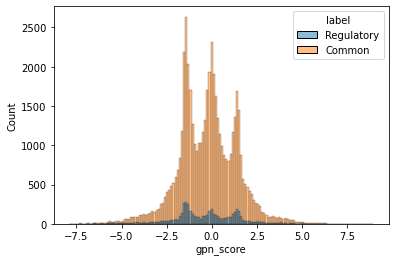

In [76]:
sns.histplot(data=df_regulatory_set, x="gpn_score", hue="label")

In [77]:
from sklearn.metrics import roc_auc_score, average_precision_score
AUROC = roc_auc_score(df_regulatory_set.label=="Regulatory", -df_regulatory_set.gpn_score)
AUPRC = average_precision_score(df_regulatory_set.label=="Regulatory", -df_regulatory_set.gpn_score)
AUROC, AUPRC

(0.5197468249413786, 0.10453511572986386)

## Plot ROC curve

In [78]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(df_regulatory_set.label=="Regulatory", -df_regulatory_set.gpn_score)

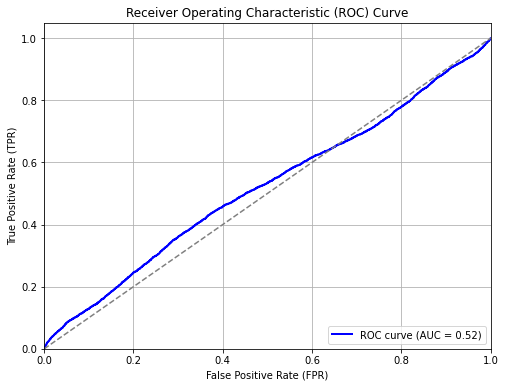

In [79]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {AUROC:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [96]:
X = df_regulatory_set['gpn_score']
y = df_regulatory_set['label']

In [97]:
X

0       -1.350500
1       -2.675772
2       -1.689601
3       -0.649784
4        1.473073
           ...   
61165    0.809759
61166   -0.432821
61167   -0.782855
61168    1.153756
61169   -0.287936
Name: gpn_score, Length: 57514, dtype: float64

In [98]:
y

0        Regulatory
1        Regulatory
2        Regulatory
3        Regulatory
4        Regulatory
            ...    
61165        Common
61166        Common
61167        Common
61168        Common
61169        Common
Name: label, Length: 57514, dtype: object

In [99]:
X = X.values.reshape(-1,1)

In [100]:
y = df_regulatory_set['label'] == 'Regulatory'
y = y.astype(int)

In [101]:
y

0        1
1        1
2        1
3        1
4        1
        ..
61165    0
61166    0
61167    0
61168    0
61169    0
Name: label, Length: 57514, dtype: int64

In [102]:
from sklearn.model_selection import train_test_split
test_size = 0.3
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [103]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(solver='lbfgs', max_iter=1000)
lr_train_model = lr_model.fit(X_train,y_train)
pred_lr = lr_model.predict(X_test)

In [105]:
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, roc_auc_score

print("Accuracy_model_lr: %.4f" % (accuracy_score(y_test, pred_lr))) 
print("F1_model_lr: %.4f" % (f1_score(y_test, pred_lr)))
print("MCC_model_lr: %.4f" % (matthews_corrcoef(y_test, pred_lr)))
print("ROC_AUC_model_lr: %.4f" % (roc_auc_score(y_test, pred_lr))) # don't know about call: y_score vs. pred

Accuracy_model_lr: 0.9120
F1_model_lr: 0.0000
MCC_model_lr: 0.0000
ROC_AUC_model_lr: 0.5000


/cm/shared/apps/spack/0.17.3/cpu/b/opt/spack/linux-rocky8-zen/gcc-8.5.0/anaconda3-2021.05-q4munrgvh7qp4o7r3nzcdkbuph4z7375/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in scalar divide
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [106]:
model1 = XGBClassifier() 
model2 = XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, subsample=0.5) 
train_model1 = model1.fit(X_train, y_train) 
train_model2 = model2.fit(X_train, y_train) 
pred1 = train_model1.predict(X_test) 
pred2 = train_model2.predict(X_test) 
print("Accuracy_model1: %.4f" % (accuracy_score(y_test, pred1))) 
print("Accuracy_model2: %.4f" % (accuracy_score(y_test, pred2))) 
print("F1_model1: %.4f" % (f1_score(y_test, pred1)))
print("F1_model2: %.4f" % (f1_score(y_test, pred2)))
print("MCC_model1: %.4f" % (matthews_corrcoef(y_test, pred1)))
print("MCC_model2: %.4f" % (matthews_corrcoef(y_test, pred2)))
print("ROC_AUC_model1: %.4f" % (roc_auc_score(y_test, pred1))) # don't know about call: y_score vs. pred
print("ROC_AUC_model2: %.4f" % (roc_auc_score(y_test, pred2))) # don't know about call: y_score vs. pred

Accuracy_model1: 0.9120
Accuracy_model2: 0.9120
F1_model1: 0.0000
F1_model2: 0.0000
MCC_model1: 0.0000
MCC_model2: 0.0000
ROC_AUC_model1: 0.5000
ROC_AUC_model2: 0.5000


/cm/shared/apps/spack/0.17.3/cpu/b/opt/spack/linux-rocky8-zen/gcc-8.5.0/anaconda3-2021.05-q4munrgvh7qp4o7r3nzcdkbuph4z7375/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in scalar divide
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/cm/shared/apps/spack/0.17.3/cpu/b/opt/spack/linux-rocky8-zen/gcc-8.5.0/anaconda3-2021.05-q4munrgvh7qp4o7r3nzcdkbuph4z7375/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in scalar divide
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [112]:
tn, fp, fn, tp = confusion_matrix(y_test, pred1).ravel()
print(tp, fp, fn, tn)

0 0 1519 15736


In [113]:
tn, fp, fn, tp = confusion_matrix(y_test, pred2).ravel()
print(tp, fp, fn, tn)

0 0 1519 15736


In [107]:
model3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=7)

train_model3 = model3.fit(X_train, y_train)
pred3 = train_model3.predict(X_test)
print("Accuracy_model3: %.4f" % (accuracy_score(y_test, pred3)))
print("F1_model3: %.4f" % (f1_score(y_test, pred3)))
print("MCC_model3: %.4f" % (matthews_corrcoef(y_test, pred3)))
print("ROC_AUC_model3: %.4f" % (roc_auc_score(y_test, pred3))) # don't know about call: y_score vs. pred


Accuracy_model3: 0.9120
F1_model3: 0.0000
MCC_model3: 0.0000
ROC_AUC_model3: 0.5000


/cm/shared/apps/spack/0.17.3/cpu/b/opt/spack/linux-rocky8-zen/gcc-8.5.0/anaconda3-2021.05-q4munrgvh7qp4o7r3nzcdkbuph4z7375/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in scalar divide
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [111]:
tn, fp, fn, tp = confusion_matrix(y_test, pred3).ravel()
print(tp, fp, fn, tn)

0 0 1519 15736


In [109]:
train_model_regbase = model_regbase.fit(X_train, y_train)
#pred_regbase = train_model_regbase.predict(X_val)
#print("Accuracy_model_regbase: %.4f" % (accuracy_score(y_val, pred_regbase)))
#print("F1_model_regbase: %.4f" % (f1_score(y_val, pred_regbase)))
#print("MCC_model_regbase: %.4f" % (matthews_corrcoef(y_val, pred_regbase)))
#print("ROC_AUC_model_regbase: %.4f" % (roc_auc_score(y_val, pred_regbase)))
pred_regbase = train_model_regbase.predict(X_test)
print("Accuracy_model_regbase: %.4f" % (accuracy_score(y_test, pred_regbase)))
print("F1_model_regbase: %.4f" % (f1_score(y_test, pred_regbase)))
print("MCC_model_regbase: %.4f" % (matthews_corrcoef(y_test, pred_regbase)))
print("ROC_AUC_model_regbase: %.4f" % (roc_auc_score(y_test, pred_regbase)))

Accuracy_model_regbase: 0.9120
F1_model_regbase: 0.0000
MCC_model_regbase: 0.0000
ROC_AUC_model_regbase: 0.5000


/cm/shared/apps/spack/0.17.3/cpu/b/opt/spack/linux-rocky8-zen/gcc-8.5.0/anaconda3-2021.05-q4munrgvh7qp4o7r3nzcdkbuph4z7375/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in scalar divide
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [110]:
tn, fp, fn, tp = confusion_matrix(y_test, pred_regbase).ravel()
print(tp, fp, fn, tn)

0 0 1519 15736
